In [6]:
from typing import List
import torch
import torch.nn.functional as F
import numpy as np
from data  import create_dataloader, MVTecAD
from model import DenoiseDiffusion, UNet, DiscriminativeSubNetwork
import os
os.chdir("/workspace/")


In [2]:
cfg={}
cfg['image_channels'] = 3
cfg['n_channels'] = 128 #number of channels in the initial feature map
cfg['channel_multipliers']: List[int] = [1, 2, 2, 2, 2],
cfg['is_attention']:List[bool] = [False, False, True, True, True],
cfg['n_blocks'] = 2
cfg['train_timestamp'] = 1000
cfg['n_steps'] = 1000
cfg['batch_size'] = 2
cfg['lr'] = 1e-4
cfg['device'] = 'cuda'

In [3]:
eps_model =UNet(
    image_channels=3, #rgb 3채널
    n_channels=128, #number of channels in the initial feature map 
    ch_mults=[1, 2, 2, 2, 2], #channel multiplier
    is_attn=[False, False, True, True, True], #attention
    n_blocks=2
).to("cuda")

In [4]:
diffusion = DenoiseDiffusion(
    eps_model=eps_model,
    n_steps=cfg['n_steps'],
    device=cfg['device'],
).to(cfg['device'])

In [ ]:
DiscriminativeSubNetwork(in_channels=6, out_channels=2).to(cfg["device"])

In [5]:
diffusion.parameters

<bound method Module.parameters of DenoiseDiffusion(
  (eps_model): UNet(
    (image_proj): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_emb): TimeEmbedding(
      (lin1): Linear(in_features=128, out_features=512, bias=True)
      (act): Swish()
      (lin2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down): ModuleList(
      (0-1): 2 x DownBlock(
        (res): ResidualBlock(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (act1): Swish()
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (act2): Swish()
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (shortcut): Identity()
          (time_emb): Linear(in_features=512, out_features=128, bias=True)
          (time_act): Swish()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (attn): Ide

In [3]:
data_set = MVTecAD(
    datadir='./dataset/mvtec_ad',
    target='capsule',
    train=True,
    img_size=256,
    texture_source_dir='./dataset/dtd/images',
    grid_size=8,
    perlin_noise_threshold=0.5,
    textual_or_structural='structural',
    transparency_range=[0.15, 1.0],
    self_aug='self-augmentation'
)
data_loader = create_dataloader(
    dataset=data_set,
    train=True,
    batch_size=cfg['batch_size'],
    num_workers=1
)



In [6]:
for step, batch in enumerate(data_loader):
    images, masks = batch[0].to(cfg['device']), batch[1].to(cfg['device'])
    # Sample noise to add to the images
    noise = torch.randn(images.shape).to(images.device)
    bs = images.shape[0]

    # Sample a random timestep for each image
    #timesteps = torch.randint(cfg['train_timestamp'], (bs,), device=images.device).long()
    timesteps = torch.randint(50, (bs,), device=images.device).long()

    # add noise to the images
    noisy_images = diffusion.q_sample(images, timesteps, noise)

    # predict the noise
    pred_noise = diffusion.eps_model(noisy_images, timesteps)

    Loss = F.mse_loss(pred_noise, noise)

    #predict image (inference)
    predicted_images = diffusion.p_sample(noisy_images, timesteps)
    
    break

/usr/local/lib/python3.10/site-packages/imgaug/augmenters/base.py:27: SuspiciousMultiImageShapeWarning: You provided a numpy array of shape (256, 256, 3) as a multi-image augmentation input, which was interpreted as (N, H, W). The last dimension however has value 1 or 3, which indicates that you provided a single image with shape (H, W, C) instead. If that is the case, you should use e.g. augmenter(image=<your input>) or augment_image(<your input>) -- note the singular 'image' instead of 'imageS'. Otherwise your single input image will be interpreted as multiple images of shape (H, W) during augmentation.
  ia.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


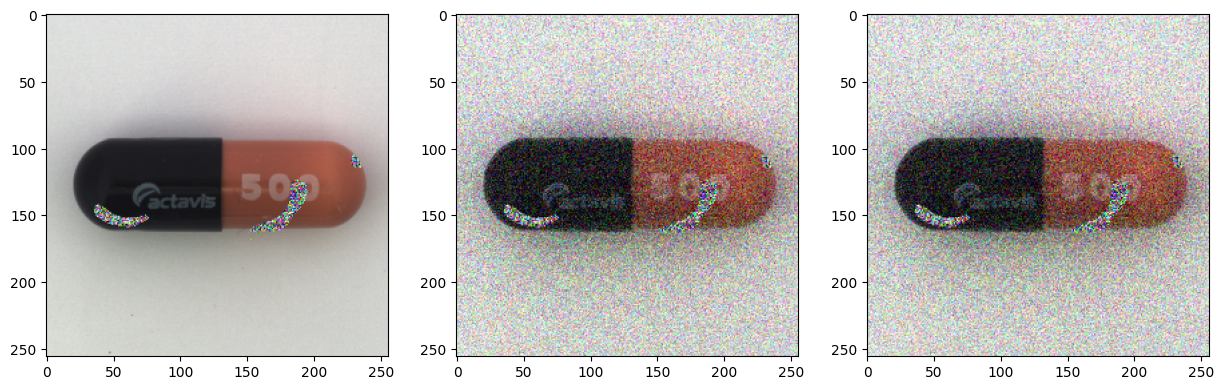

Loss:  1.0747613906860352
Timestep:  36


In [7]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1, 3, figsize=(15, 5))
image = images[1].unsqueeze(0).to('cpu')
image = image.squeeze().numpy().transpose(1, 2, 0)
noisy_image = noisy_images[1].unsqueeze(0).to('cpu')
noisy_image = noisy_image.squeeze().numpy().transpose(1, 2, 0)
predicted_image = predicted_images[1].unsqueeze(0).to('cpu')
predicted_image = predicted_image.squeeze().detach().numpy().transpose(1, 2, 0)
ax[0].imshow(image)
ax[1].imshow(noisy_image)
ax[2].imshow(predicted_image)
plt.show()
print('Loss: ', Loss.item())
print('Timestep: ', timesteps[1].item())


In [4]:
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_constant_schedule #, get_cosine_schedule_with_warmup


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model = UNet2DModel(
    sample_size=256,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
).to(cfg['device'])

In [6]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [40]:
sample_image = data_set[0][0].unsqueeze(0).to(cfg['device'])
noise = torch.randn(sample_image.shape).to(sample_image.device)
# rand torch. long between (0 1000)
#time_steps = torch.randint(cfg['train_timestamp'], (1,), device=sample_image.device).long()
time_steps = torch.randint(50, (1,), device=sample_image.device ).long()
noisy_image = noise_scheduler.add_noise(sample_image, noise, time_steps)
pred_noise = model(noisy_image, time_steps).sample

Loss = F.mse_loss(pred_noise, noise)

/usr/local/lib/python3.10/site-packages/imgaug/augmenters/base.py:27: SuspiciousMultiImageShapeWarning: You provided a numpy array of shape (256, 256, 3) as a multi-image augmentation input, which was interpreted as (N, H, W). The last dimension however has value 1 or 3, which indicates that you provided a single image with shape (H, W, C) instead. If that is the case, you should use e.g. augmenter(image=<your input>) or augment_image(<your input>) -- note the singular 'image' instead of 'imageS'. Otherwise your single input image will be interpreted as multiple images of shape (H, W) during augmentation.
  ia.warn(


In [43]:
pred_noise.shape

torch.Size([1, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


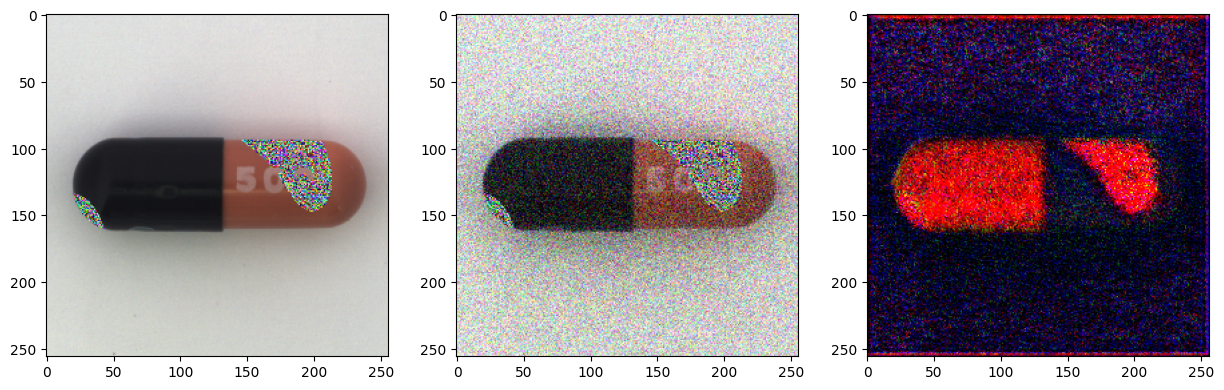

Loss:  1.0980420112609863
Timestep:  tensor([38], device='cuda:0')


In [39]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1, 3, figsize=(15, 5))
sample_image = sample_image.unsqueeze(0).to('cpu')
sample_image = sample_image.squeeze().numpy().transpose(1, 2, 0)
noisy_image = noisy_image.unsqueeze(0).to('cpu')
noisy_image = noisy_image.squeeze().numpy().transpose(1, 2, 0)
pred_noise = pred_noise.unsqueeze(0).to('cpu')
pred_noise = pred_noise.squeeze().detach().numpy().transpose(1, 2, 0)
ax[0].imshow(sample_image)
ax[1].imshow(noisy_image)
ax[2].imshow(pred_noise)
plt.show()
print('Loss: ', Loss.item())
print('Timestep: ', time_steps)
